In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch
from lsh import LSH
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from utils.torchinterp import Interp1d

In [3]:
df_train = pd.read_csv("../dataset/pointcloud_mnist_2d/train.csv")
df_test = pd.read_csv("../dataset/pointcloud_mnist_2d/test.csv")

X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()

X = X.reshape(X.shape[0], -1, 3)

X.shape, y.shape

((60000, 351, 3), (60000,))

In [4]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [5]:
X = X[:, :, 0:2]

In [6]:
from itertools import combinations
from tqdm.notebook import tqdm

In [28]:
def compute_jp(X, janossy_k, ref_size=500):
    ref_len = ref_size // janossy_k
    ref_domain = torch.linspace(0, 1, ref_len).repeat(janossy_k, 1)

    X_janossy_cat = []
    for i in range(X.shape[2]):
        X_janossy = []
        for index in tqdm(range(len(X))):
            ph = X[index, :, i].to(torch.float)
            ph = ph[ph > 0]
            ph_sorted, _ = torch.sort(ph, descending=True)

            ph_comb = torch.combinations(ph_sorted, r=janossy_k)
            ph_comb = ph_comb.mean(0)
            X_janossy.append(ph_comb)
        
        X_janossy = torch.stack(X_janossy, dim=0)
        X_janossy_cat.append(X_janossy)
    
    X_janossy_cat = torch.cat(X_janossy_cat, dim=1).squeeze()
    print(X_janossy_cat.shape)
    X_janossy_cat = X_janossy_cat.reshape(X_janossy_cat.shape[0], -1)
    print(X_janossy_cat.shape)
    return X_janossy_cat.numpy()

In [29]:
# def compute_jp(X, janossy_k, ref_size=500):
#     ref_len = ref_size // janossy_k
#     ref_domain = torch.linspace(0, 1, ref_len).repeat(janossy_k, 1)

#     X_janossy_cat = []
#     for i in range(X.shape[2]):
#         X_janossy = []
#         for index in tqdm(range(len(X))):
#             ph = X[index, :, i].to(torch.float)
#             ph = ph[ph > 0]
#             ph_sorted, _ = torch.sort(ph, descending=True)

#             ph_comb = torch.combinations(ph_sorted, r=janossy_k)
#             ph_comb_domain = torch.linspace(0, 1, ph_comb.shape[0]).repeat(janossy_k, 1)

#             ph_comb_interp = Interp1d()(ph_comb_domain, ph_comb.T, ref_domain).T

#             X_janossy.append(ph_comb_interp)
        
#         X_janossy = torch.stack(X_janossy, dim=0)
#         X_janossy_cat.append(X_janossy)
    
#     X_janossy_cat = torch.cat(X_janossy_cat, dim=1).squeeze()
#     X_janossy_cat = X_janossy_cat.reshape(X_janossy_cat.shape[0], -1)
#     return X_janossy_cat.numpy()

In [30]:
k_arr = 1

In [31]:
X_j = compute_jp(X, k_arr)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

torch.Size([60000, 2])
torch.Size([60000, 2])


In [32]:
X_j.shape

(60000, 2)

In [33]:
X_test = df_test[df_test.columns[1:]].to_numpy()
y_test = df_test[df_test.columns[0]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], -1, 3)

In [34]:
X_test = torch.from_numpy(X_test)
X_test = X_test[:, :, :2]
X_test_j = compute_jp(X_test, k_arr)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 2])
torch.Size([10000, 2])


In [35]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_j , y.numpy())

KNeighborsClassifier(n_neighbors=9)

In [36]:
preds = neigh.predict(X_test_j)
accuracy_score(preds, y_test)

0.1177

In [37]:
accs = []
num_neighs = 10
for i in tqdm(range(1, num_neighs)):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_j, y.numpy())
    preds = neigh.predict(X_test_j)
    accs.append(accuracy_score(preds, y_test))

  0%|          | 0/9 [00:00<?, ?it/s]

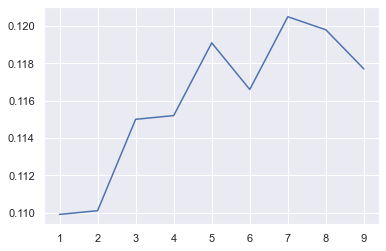

In [38]:
plt.plot(range(1, num_neighs), accs)
plt.show()

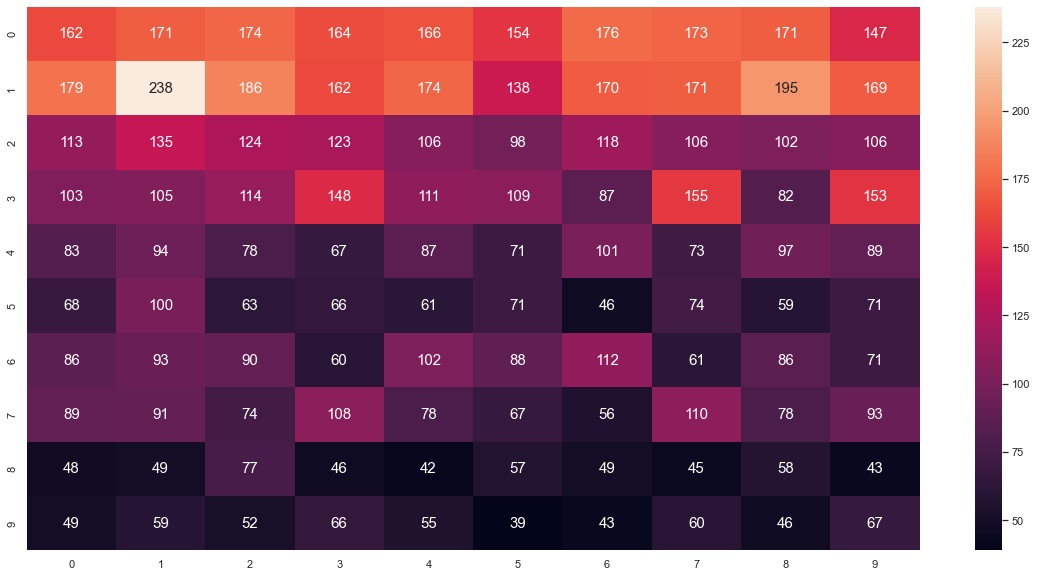

In [39]:
import seaborn as sn
cm = confusion_matrix(preds, y_test)

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(20,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g')

plt.show()

In [40]:
X_j = compute_jp(X, 2)
X_test_j = compute_jp(X_test, 2)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

torch.Size([60000, 4])
torch.Size([60000, 4])


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 4])
torch.Size([10000, 4])


In [41]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_j , y.numpy())

KNeighborsClassifier(n_neighbors=3)

In [42]:
preds = neigh.predict(X_test_j)
accuracy_score(preds, y_test)

0.3649

In [43]:
X_j.shape

(60000, 4)

In [44]:
accs = []
num_neighs = 10
for i in tqdm(range(1, num_neighs)):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_j, y.numpy())
    preds = neigh.predict(X_test_j)
    accs.append(accuracy_score(preds, y_test))

  0%|          | 0/9 [00:00<?, ?it/s]

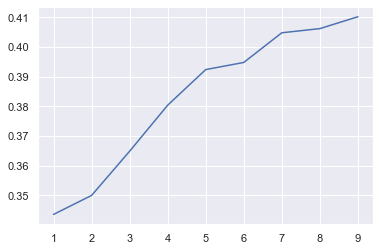

In [45]:
plt.plot(range(1, num_neighs), accs)
plt.show()